## TrOCR

In [1]:
import cv2
import os
import torch
import evaluate
from torchvision import transforms
from datasets import Dataset
import pandas as pd
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from PIL import Image, ImageOps
import numpy as np

c:\Users\minja\anaconda3\envs\TrOCR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
video_path = "dataset\\Installation of the MLG Hydraulic Dressings.mp4"
image_save_directory = "dataset\\output_framesss"

In [3]:
# 1. TroCR 모델 준비
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transfor

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

In [5]:
# 2. 마우스로 ROI 선택
roi = None
cropping = False
start_point = None

def mouse_crop(event, x, y, flags, param):
    global roi, cropping, start_point, img_copy

    if event == cv2.EVENT_LBUTTONDOWN:
        cropping = True
        start_point = (x, y)

    elif event == cv2.EVENT_LBUTTONUP:
        cropping = False
        end_point = (x, y)
        x1, y1 = start_point
        x2, y2 = end_point
        roi = (min(x1,x2), min(y1,y2), abs(x2 - x1), abs(y2 - y1))
        cv2.rectangle(img_copy, start_point, end_point, (0,255,0), 2)
        cv2.imshow("Select ROI", img_copy)

def select_roi_from_video(video_path):
    global img_copy
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise Exception("영상에서 첫 프레임을 읽을 수 없습니다.")
    
        
    frame = cv2.resize(frame, (1920, 1080))
    img_copy = frame.copy()
    cv2.imshow("Select ROI", img_copy)
    cv2.setMouseCallback("Select ROI", mouse_crop)
    print("ROI 영역을 드래그하세요. 완료 후 아무 키나 누르세요.")
    key=cv2.waitKey(0)
    
    cv2.destroyAllWindows()
    return roi

# 3. OCR 수행 함수
def ocr_infer(image):
    try:
        pil_image = Image.fromarray(image).convert("RGB")
        pixel_values = processor(images=pil_image, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return generated_text.strip()
    except Exception as e:
        print(f"OCR 실패: {e}")
        return None

# 4. 영상 처리 및 프레임 저장
def process_video(video_path, save_root):
    roi_box = select_roi_from_video(video_path)

    if roi_box:
        cap = cv2.VideoCapture(video_path)
        frame_idx = 0

        if not os.path.exists(save_root):
            os.makedirs(save_root)
        etc_path = os.path.join(save_root, "ETC")
        os.makedirs(etc_path, exist_ok=True)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_idx % 3 == 0:
                frame = cv2.resize(frame, (1920, 1080))
                x, y, w, h = roi_box
                cropped = frame[y:y+h, x:x+w]
                label = ocr_infer(cropped)
                label = label.replace("/", "_")

                # 폴더 분류 저장
                if label and len(label) > 0 and all(c.isprintable() for c in label):
                    folder_name = os.path.join(save_root, label)
                else:
                    folder_name = etc_path

                os.makedirs(folder_name, exist_ok=True)
                save_path = os.path.join(folder_name, f"{frame_idx:05}.jpg")
                cv2.imwrite(save_path, cropped)
                print(f"{frame_idx} 저장 → {folder_name}")
            
            frame_idx += 1

        cap.release()
        
    else:
        print("프로그램 종료")


process_video(video_path, image_save_directory)


ROI 영역을 드래그하세요. 완료 후 아무 키나 누르세요.
프로그램 종료


In [ ]:
# 클래스 불균형 방지
labels = os.listdir(image_save_directory)

label_length = {}
count = float("inf")

for label in labels:
    if label == "ETC":
        continue
    label_path = os.path.join(image_save_directory, label)
    
    files = os.listdir(label_path)
    label_length[label] = files

    if count > len(files):
        count = len(files)

print("가장 적은 프레임 수:", count)

# count보다 적은 파일들 제거
for label, files in label_length.items():
    label_path = os.path.join(image_save_directory, label)
    
    if len(files) > count:
        for delete_file in files[count:]:
            os.remove(os.path.join(label_path, delete_file))

가장 적은 프레임 수: 273


In [6]:
# 커스텀 데이터셋 준비
def load_data(image_root):
    records = []
    for label in os.listdir(image_root):
        label_path = os.path.join(image_root, label)
        for filename in os.listdir(label_path):
            if filename.endswith((".jpg", ".png")):
                records.append({
                    "image_path": os.path.join(label_path, filename),
                    "label": label.replace("_", "/")
                })
                
    return pd.DataFrame(records)


data = load_data(image_save_directory)
dataset = Dataset.from_pandas(data)

# 전처리
def pad_to_square(image, target_size=384):
    w, h = image.size
    scale = min(target_size / w, target_size / h)
    resized = image.resize((int(w * scale), int(h * scale)))
    padded = ImageOps.pad(resized, (target_size, target_size), color=(0, 0, 0))
    return padded

def preprocess(data):
    image = Image.open(data['image_path']).convert("RGB")
    image = pad_to_square(image, target_size=384)
    pixel_values = processor(images=image, return_tensors="pt").pixel_values[0]
    labels = processor.tokenizer(data['label'], padding="max_length", max_length=10, truncation=True).input_ids
    labels = [l if l != processor.tokenizer.pad_token_id else -100 for l in labels]
    return {
        "pixel_values": pixel_values,
        "labels": torch.tensor(labels)
    }

processed_dataset = dataset.map(preprocess)
processed_dataset = processed_dataset.remove_columns(["label", "image_path"])

split_dataset = processed_dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

Map: 100%|██████████| 17745/17745 [04:39<00:00, 63.50 examples/s]  


📸 pixel_values (shape): torch.Size([3, 384, 384])
pixel_values (sample): tensor([[[-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]],

        [[-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]],

        [[-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

🔤 labels (token IDs): tensor([   0, 1640, 1225,   73, 3506,   43,    2, -100, -100, -100])
label 원문: (11/65)
🔁 디코딩된 텍스트: <s>(11/65)</s>


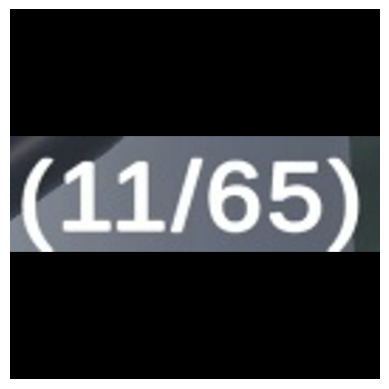

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# 데이터셋 로딩
example = dataset[334]  # 첫 번째 샘플

# 전처리 적용
processed = preprocess(example)

# 출력
pixel_values = processed["pixel_values"]
print("📸 pixel_values (shape):", pixel_values.shape)
print("pixel_values (sample):", pixel_values[:, :5, :5])  # 일부만 출력

print("\n🔤 labels (token IDs):", processed["labels"])
print("label 원문:", example["label"])
decoded = processor.tokenizer.decode([id for id in processed["labels"] if id != -100])
print("🔁 디코딩된 텍스트:", decoded)

inv_transform = T.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
image_restored = inv_transform(pixel_values).clamp(0, 1)

image_np = image_restored.permute(1, 2, 0).cpu().numpy()

plt.imshow(image_np)
plt.axis("off")
plt.show()

In [8]:
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # -100 padding을 tokenizer pad_token_id로 바꿔서 디코딩할 수 있게 함
    labels = [[(l if l != -100 else processor.tokenizer.pad_token_id) for l in label] for label in labels]

    decoded_preds = processor.tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    wer = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    return {
        "cer": cer,
        "wer": wer,
    }

# 학습 설정
training_args = Seq2SeqTrainingArguments(
    output_dir="dataset/trocr_finetuned",
    per_device_train_batch_size = 8,
    learning_rate = 5e-5,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir="./logs",
    predict_with_generate=True,
    generation_max_length=10,
    fp16=torch.cuda.is_available(),
    eval_strategy="epoch",
)

# 트레이너 실행
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)

c:\Users\minja\anaconda3\envs\TrOCR\lib\site-packages\transformers\models\trocr\processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
C:\Users\minja\AppData\Local\Temp\ipykernel_8716\4211797996.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [9]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id

In [10]:
trainer.train()

# 학습이 끝난 후 테스트셋에서 CER 평가
eval_results = trainer.evaluate()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Cer,Wer
1,0.000000,0.000001,0.562554,1.000000


In [11]:
print(f"Test WER: {eval_results['eval_wer']:.4f}")
print(f"Test CER: {eval_results['eval_cer']:.4f}")

Test WER: 1.0000
Test CER: 0.5626


In [12]:
model.save_pretrained("trocr_custon_model")
processor.save_pretrained("trocr_custon_model")

[]

In [ ]:
# 저장한 모델 디렉토리로부터 로드
model = VisionEncoderDecoderModel.from_pretrained("trocr_custon_model-custom")
processor = TrOCRProcessor.from_pretrained("trocr_custon_model-custom")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [13]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # 텍스트 생성
    generated_ids = model.generate(pixel_values, max_length=10)
    generated_text = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_text


image_path = "dataset\\output_frames\\(35_65)\\37330.jpg"

predicted_label = predict_image(image_path)
print(predicted_label)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset\\output_frames\\(35_65)\\37330.jpg'